# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [1]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package

from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

### **Loading the catalog**

In [2]:
# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name='appointment_attendance')

# set up output directories
for i in ['outputs/assumptions', 'outputs/plots', 'outputs/tables']:
    if not os.path.exists(i):
        os.makedirs(i)

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [3]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,NOV2021,Attended,GP,Face-to-Face,1 Day,2258
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,NOV2021,Attended,GP,Face-to-Face,15 to 21 Days,633
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,NOV2021,Attended,GP,Face-to-Face,2 to 7 Days,4791
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,NOV2021,Attended,GP,Face-to-Face,22 to 28 Days,296
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,NOV2021,Attended,GP,Face-to-Face,8 to 14 Days,1871


#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [4]:
# Function to convert months to FY-YEARS
def convert_to_fy(timestamp):
    if timestamp.month >=4:
        return timestamp.year
    else:
        return timestamp.year - 1 

In [5]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

combined_df_copy['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH'], format="%b%Y").dt.to_period('M')
    
combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021']
combined_df_copy['APPOINTMENT_MONTH'].unique()

<PeriodArray>
['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
 '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
 '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
 '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02',
 '2024-03', '2024-04']
Length: 30, dtype: period[M]

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [6]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
attended_df['FY_YEAR'] = attended_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments attended
attended_df_mean = attended_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
attended_df_mean['COUNT_OF_APPOINTMENTS'] = attended_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
attended_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021               450267.0
                                                   FY2022               459362.6
                                                   FY2023               482903.8
                                                   FY2024               502639.0
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               413790.6

2023 ka average match islie nahe ho raha hai kyunki divide 12 se nahe balki 5 se ho raha hai kyunki data me august/23 tak ka data ha FY23 k lie

In [7]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
do_not_attend_df['FY_YEAR'] = do_not_attend_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
dna_df_mean = do_not_attend_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
dna_df_mean['COUNT_OF_APPOINTMENTS'] = dna_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
dna_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                14767.8
                                                   FY2022                16003.8
                                                   FY2023                16256.1
                                                   FY2024                15545.0
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                18061.2

In [8]:
# Dataframe for appointments DNA
unknown_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Unknown'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
unknown_df['FY_YEAR'] = unknown_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
unknown_df_mean = unknown_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = unknown_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
unknown_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                18343.2
                                                   FY2022                16197.5
                                                   FY2023                31219.6
                                                   FY2024                27324.0
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                14796.4

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [9]:
# Convert the 'count_column' to numeric
attended_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(attended_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_attended_2021 = attended_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_attended_2022 = attended_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_attended_2023_april_august = attended_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_attended = attended_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended_2021.item()} is the National average for attended appointments(FY-2021)')
print(f'{National_average_attended_2022.item()} is the National average for attended appointments(FY-2022)')
print(f'{National_average_attended_2023_april_august.item()} is the National average for attended appointments(FY-2023, april-august)')

SNEE_average_attended

593355.96 is the National average for attended appointments(FY-2021)
608099.22 is the National average for attended appointments(FY-2022)
629295.9 is the National average for attended appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,455598.6
FY2022,465021.9
FY2023,487052.6
FY2024,548835.0


#### **2. Not attended (DNA) Appointments**

In [10]:
# Convert the 'count_column' to numeric
dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_dna_2021 = dna_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_dna_2022 = dna_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_dna_2023_april_august = dna_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_DNA = dna_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

28898.14 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
31723.1 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,17140.6
FY2022,17822.6
FY2023,16479.8
FY2024,15710.0


#### **3. Unknown Appointments**

In [11]:
# Convert the 'count_column' to numeric
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(unknown_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_unknown_2021 = unknown_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_unknown_2022 = unknown_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_unknown_2023_april_august = unknown_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_unknown = unknown_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_unknown_2021.item()} is the National average for Unknown appointments(FY-2021)')
print(f'{National_average_unknown_2022.item()} is the National average for Unknown appointments(FY-2022)')
print(f'{National_average_unknown_2023_april_august.item()} is the National average for Unknown appointments(FY-2023, april-august)')

SNEE_average_unknown

25816.97 is the National average for Unknown appointments(FY-2021)
27095.84 is the National average for Unknown appointments(FY-2022)
38691.91 is the National average for Unknown appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,15802.2
FY2022,16936.3
FY2023,27284.0
FY2024,26191.0


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

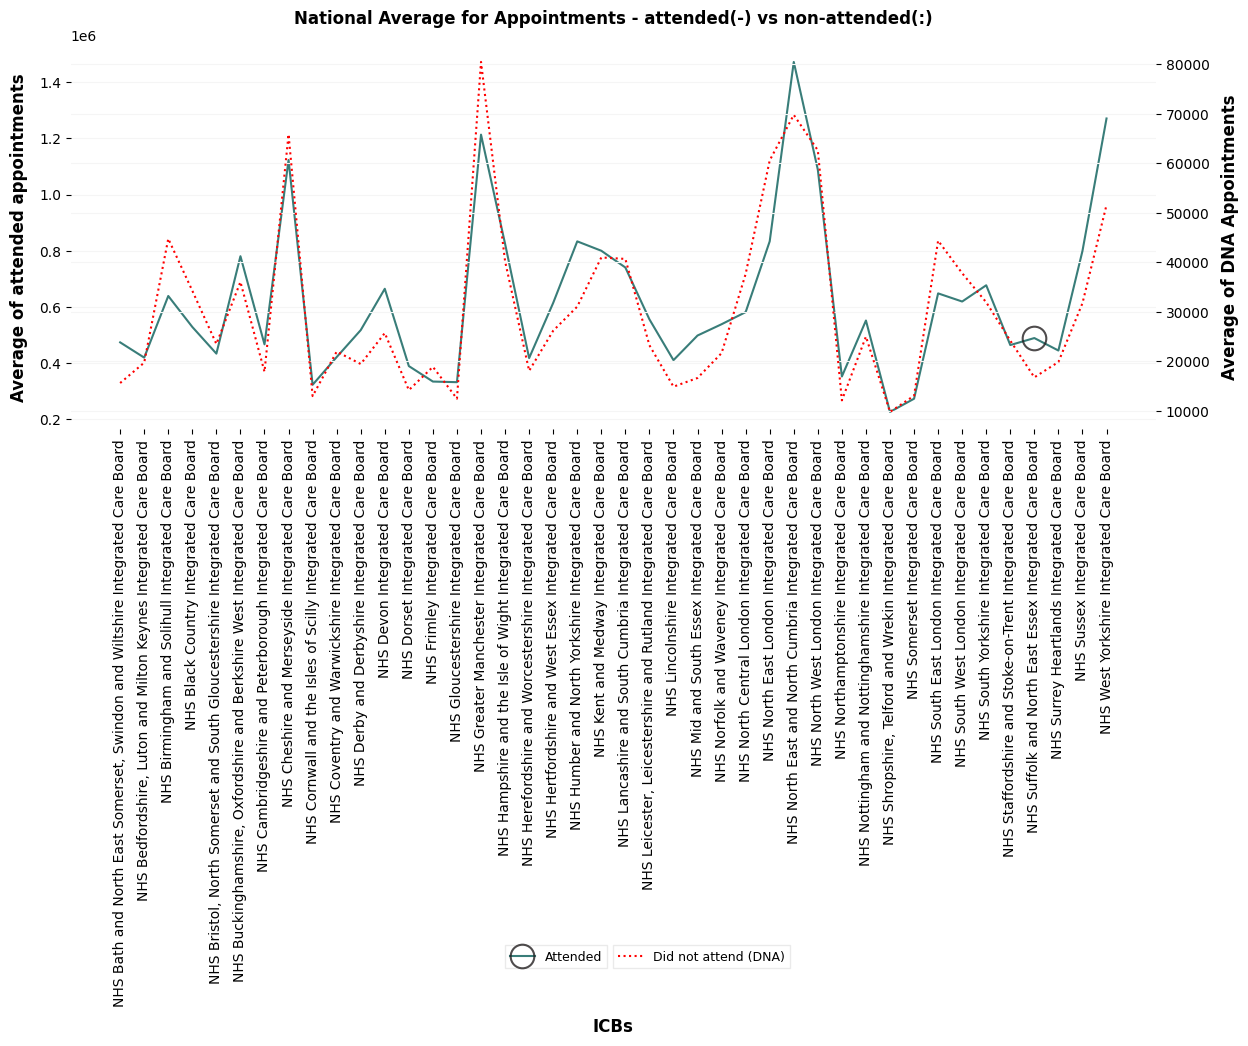

In [12]:
attended_df_mean2 = attended_df_mean.groupby('ICB_NAME').mean().reset_index()
dna_df_mean2 = dna_df_mean.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

# Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df_mean2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(0.6,30000), xytext=(36,60000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc =(0.4,-1.4))

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')
ax2.legend(loc =(0.5,-1.4))

plt.savefig(f'{plot_counter.plot_name}.png', dpi=300, bbox_inches='tight')

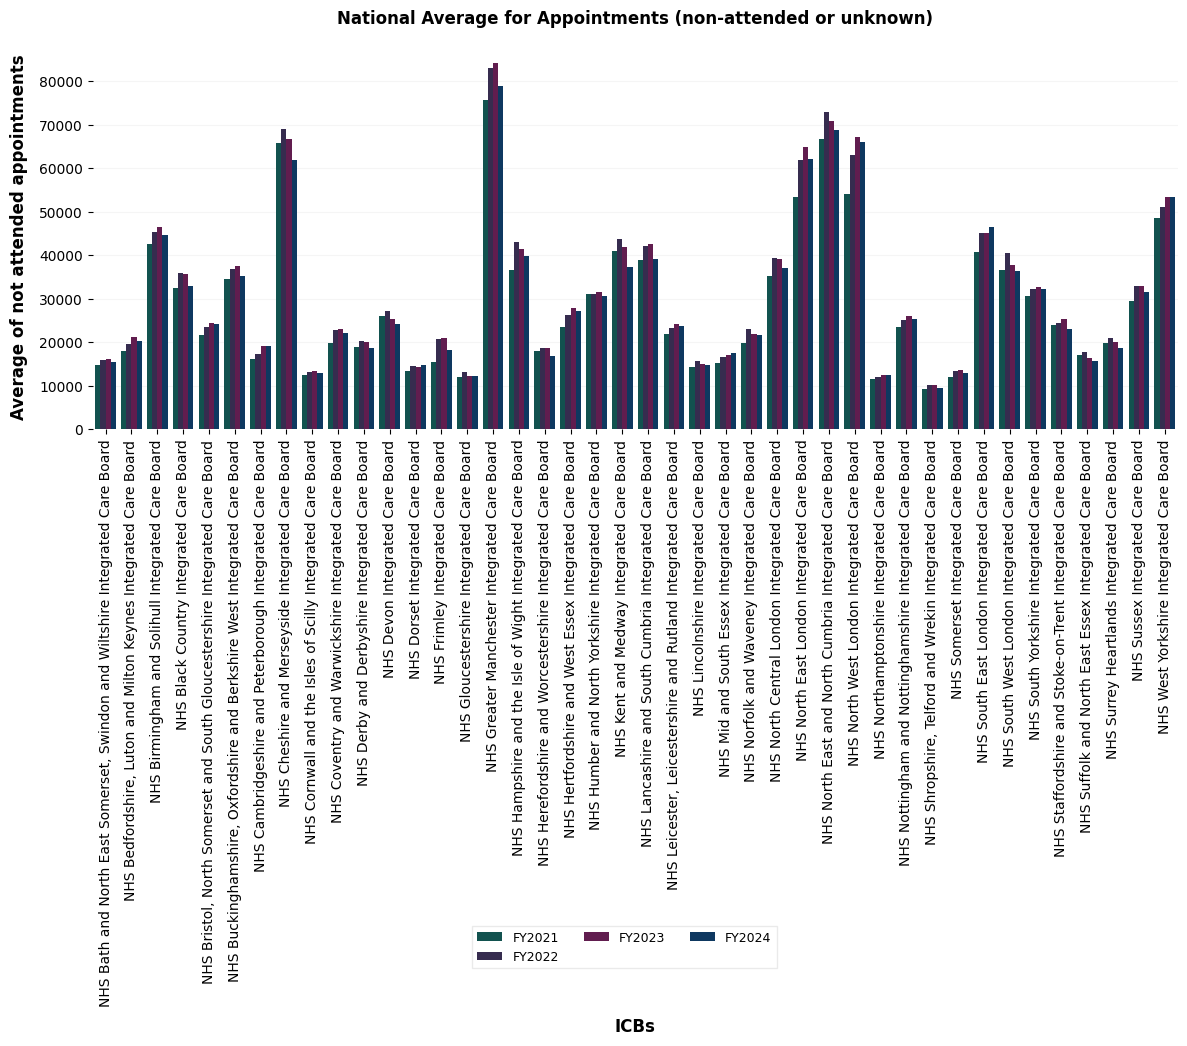

In [13]:
# Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.legend(loc=(0.35,-1.4), ncol=3)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [14]:
combined_df_copy

,ICB_NAME,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,COUNT_OF_APPOINTMENTS
0,NHS West Yorkshire Integrated Care Board,02T,2021-11,Attended,GP,Face-to-Face,2258
1,NHS West Yorkshire Integrated Care Board,02T,2021-11,Attended,GP,Face-to-Face,633
2,NHS West Yorkshire Integrated Care Board,02T,2021-11,Attended,GP,Face-to-Face,4791
3,NHS West Yorkshire Integrated Care Board,02T,2021-11,Attended,GP,Face-to-Face,296
4,NHS West Yorkshire Integrated Care Board,02T,2021-11,Attended,GP,Face-to-Face,1871
...,...,...,...,...,...,...,...
6126,"NHS Bath and North East Somerset, Swindon and ...",92G,2024-04,Unknown,Unknown,Unknown,195
6127,"NHS Bath and North East Somerset, Swindon and ...",92G,2024-04,Unknown,Unknown,Unknown,268
6128,"NHS Bath and North East Somerset, Swindon and ...",92G,2024-04,Unknown,Unknown,Unknown,467
6129,"NHS Bath and North East Somerset, Swindon and ...",92G,2024-04,Unknown,Unknown,Unknown,73


In [15]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face                3653273
                                                            Home Visit                    57525
                                                            Telephone                   2462197
                                                            Unknown                        5424
                                                            Video/Online                  66022
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                   6584
                                                            Home Visit                     3591
                                                            Telephone                     50177
                                                            Unknown                     1002101
                                                            Video/Online                    202

[603 rows x 1 columns]

In [16]:
# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face                  94992
                                                                        Home Visit                      522
                                                                        Telephone                      9163
                                                                        Unknown                         283
                                                                        Video/Online                    761
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                   6654
                                                   Unknown              Face-to-Face                      4
                                                                        Home Visit                       59
                                                                        Telephone                       599
                                                                        Unknown                       30596

[566 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [17]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,204835.1905,566873.7857,1210.0556
Home visit,1669.0238,2707.4762,1215.1389
Telephone,67684.7143,67826.4524,2201.0000
Unknown,1834.9762,3909.4762,11399.2903
Video/Online,1518.5476,3161.4048,22.1429


In [18]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face                  75895
                     Home Visit                      610
                     Telephone                     15003
                     Unknown                         314
                     Video/Online                    948
Other Practice staff Face-to-Face                 358583
                     Home Visit                     2067
                     Telephone                     18928
                     Unknown                        1179
                     Video/Online                   4553
Unknown              Face-to-Face                  22003
                     Home Visit                      162
                     Telephone                        81
                     Unknown                       12716

<Axes: >

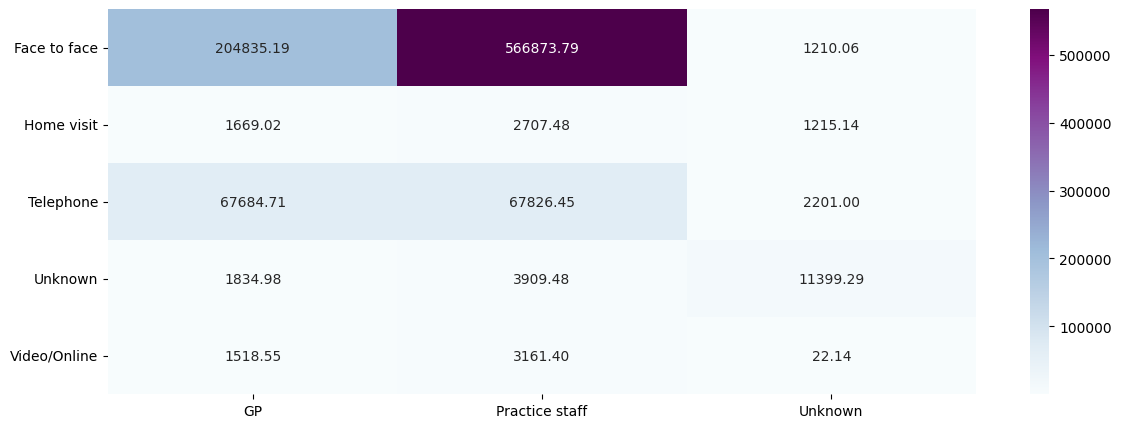

In [19]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

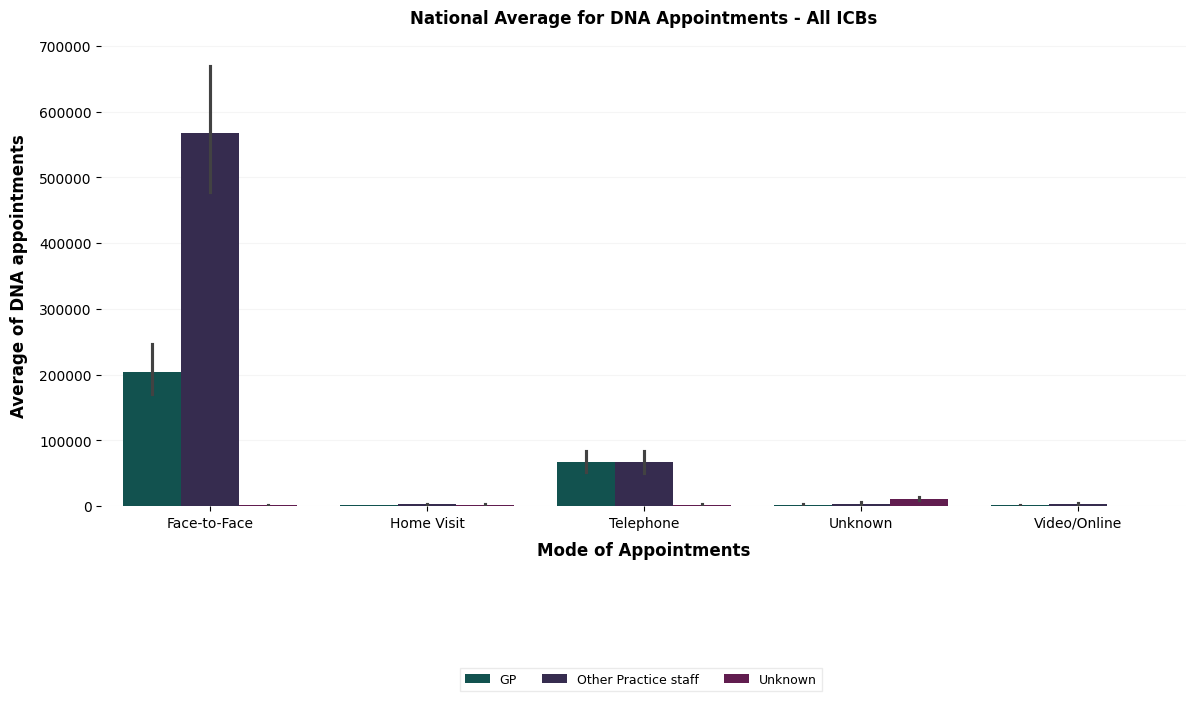

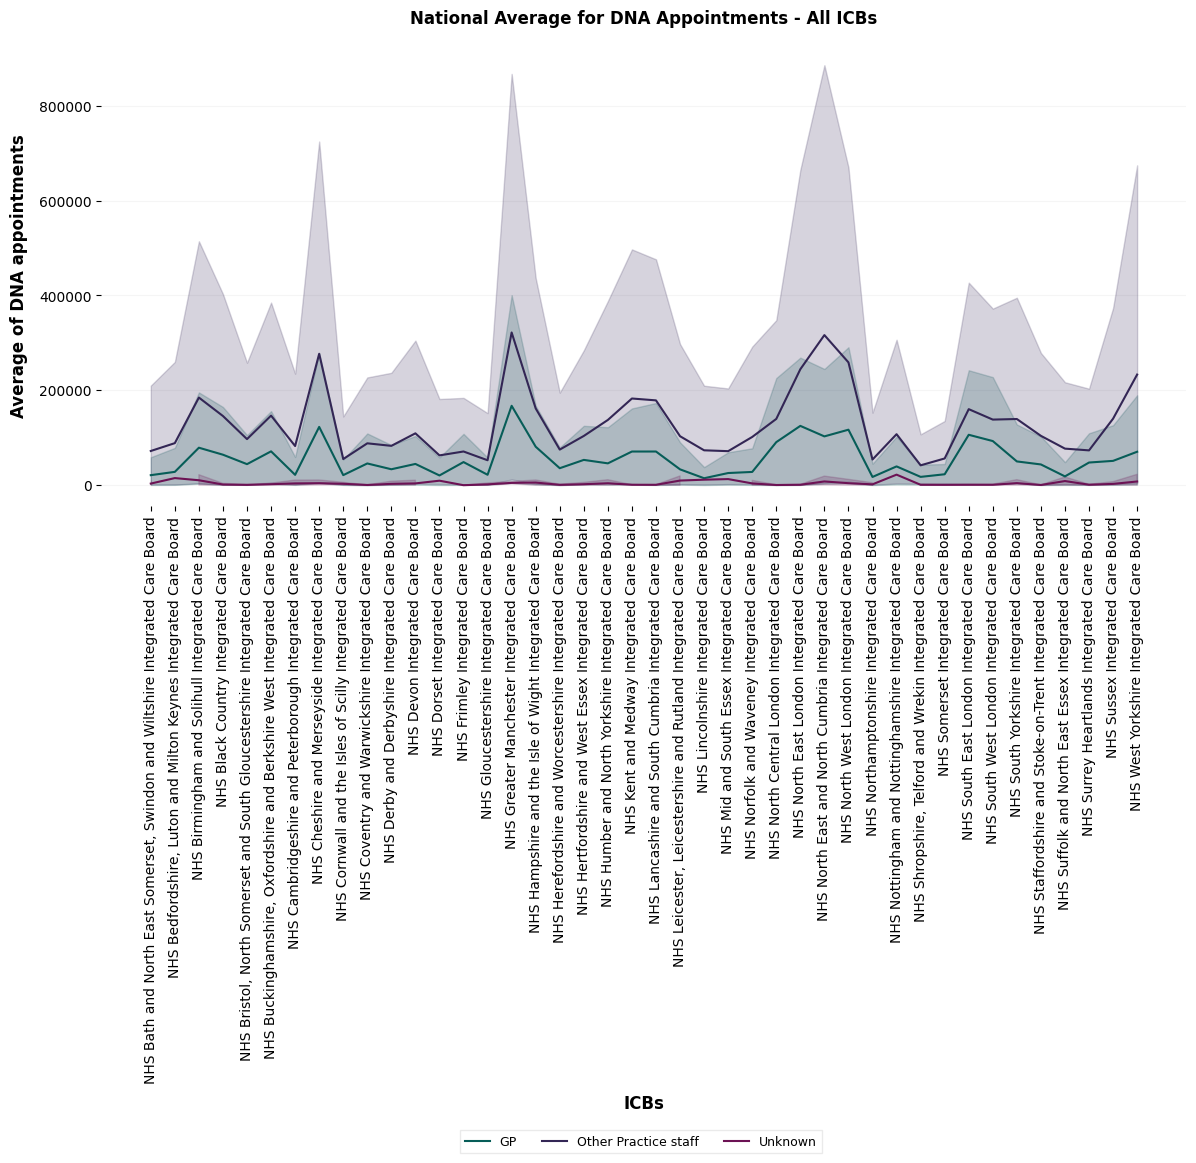

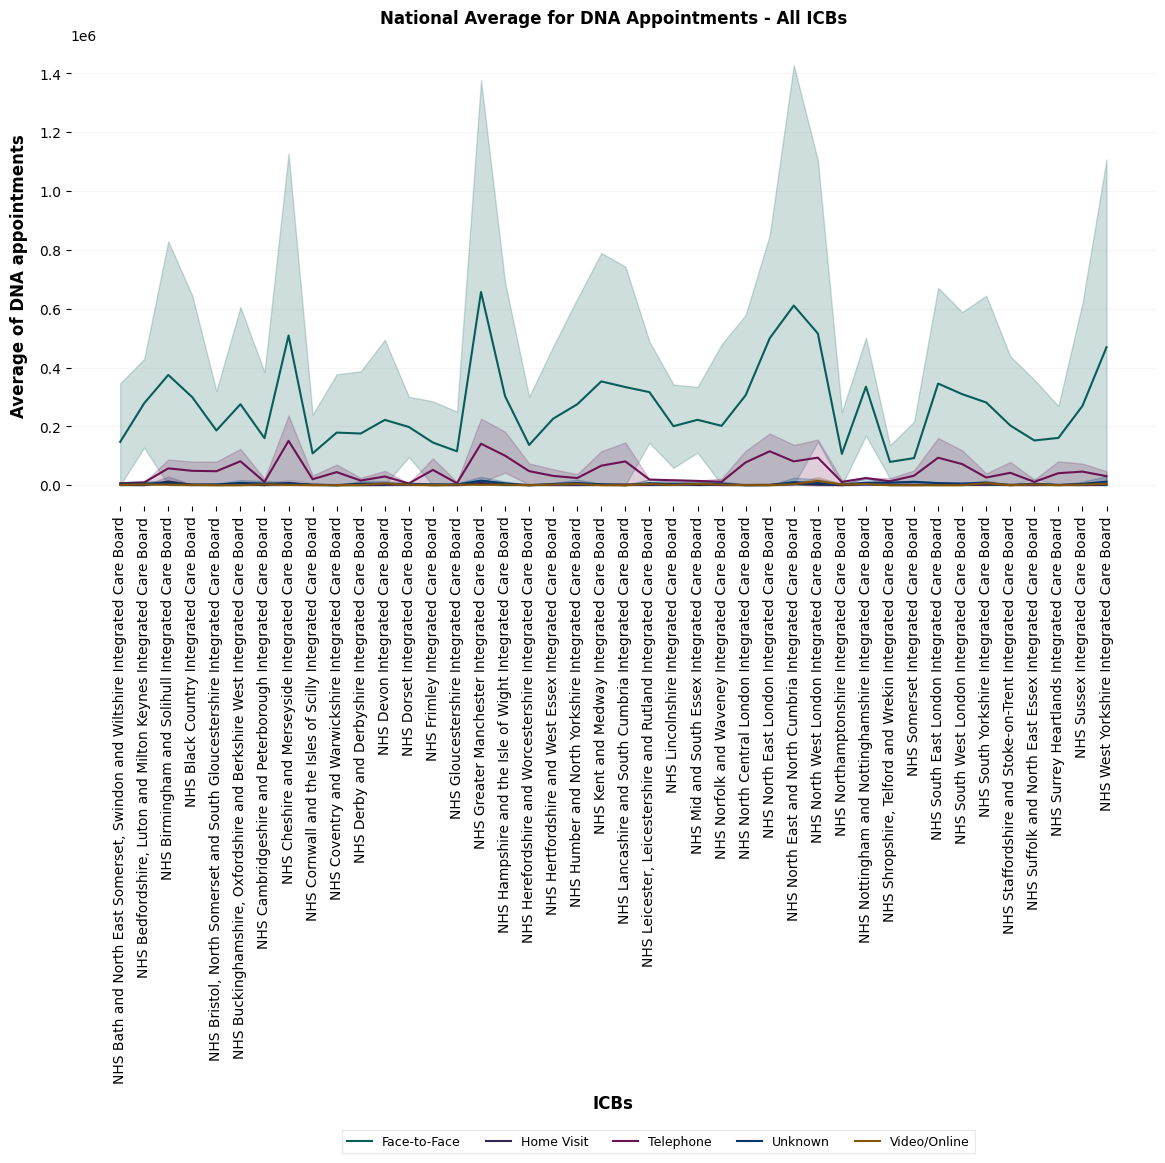

In [20]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-0.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-1.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.25,-1.4), ncol=5)

## **Analysis using proportion(%) of appointments**

### **Proportion based on FY-YEARS**

In [21]:
appt_proportion = combined_df_copy.loc[:,['SUB_ICB_LOCATION_CODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion.sum(axis=1)
appt_proportion = appt_proportion.div(sum_row, axis=0)*100
appt_proportion = appt_proportion.reset_index()
appt_proportion.columns = ['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']
appt_proportion.head()

,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,Attended,DNA,Unknown
0,00L,2021-11,93.542097,3.352270,3.105633
1,00L,2021-12,93.440911,3.525392,3.033697
2,00L,2022-01,94.083735,3.280311,2.635953
3,00L,2022-02,94.529020,3.119836,2.351144
4,00L,2022-03,94.206555,3.259615,2.533831


In [22]:
# Converting months into FY-years
appt_proportion['FY_YEAR'] = appt_proportion['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
appt_proportion_fy = appt_proportion.drop(columns=['APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','FY_YEAR']).mean().round(2)
appt_proportion_fy.head()

Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
00L                   FY2021      93.96  3.31     2.73
                      FY2022      93.08  3.69     3.23
                      FY2023      91.12  3.66     5.21
                      FY2024      91.82  3.42     4.76
00N                   FY2021      91.69  4.20     4.11

In [23]:
snee_sub_icb = ['06L','06T','07K']

National_proportion_2021 = appt_proportion_fy.loc[slice(None),'FY2021',:].mean().round(2)
National_proportion_2022 = appt_proportion_fy.loc[slice(None),'FY2022',:].mean().round(2)
National_proportion_2023_april_august = appt_proportion_fy.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_sub_icb_proportion = appt_proportion_fy.loc[snee_sub_icb,:]


print(f'{National_proportion_2021} is the National PROPORTION for appointments(FY-2021)')
print(f'{National_proportion_2022} is the National PROPORTION for appointments(FY-2022)')
print(f'{National_proportion_2023_april_august} is the National PROPORTION for appointments(FY-2023, april-august)')

SNEE_sub_icb_proportion

Attended    91.48
DNA          4.41
Unknown      4.11
dtype: float64 is the National PROPORTION for appointments(FY-2021)
Attended    91.21
DNA          4.63
Unknown      4.17
dtype: float64 is the National PROPORTION for appointments(FY-2022)
Attended    90.06
DNA          4.44
Unknown      5.50
dtype: float64 is the National PROPORTION for appointments(FY-2023, april-august)


Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
06L                   FY2021      93.80  2.73     3.47
                      FY2022      93.62  2.79     3.59
                      FY2023      91.58  2.75     5.67
                      FY2024      93.46  2.14     4.40
06T                   FY2021      91.43  4.91     3.66
                      FY2022      91.16  4.91     3.92
                      FY2023      90.67  3.85     5.49
                      FY2024      91.28  3.65     5.06
07K                   FY2021      94.98  2.74     2.28
                      FY2022      94.88  2.84     2.29
                      FY2023      93.44  2.67     3.89
                      FY2024      93.97  2.29     3.74

In [24]:
SNEE_proportion = SNEE_sub_icb_proportion.reset_index().drop(columns=['SUB_ICB_LOCATION_CODE']).groupby(['FY_YEAR']).mean().round(2)
SNEE_proportion

,Attended,DNA,Unknown
FY_YEAR,,,
FY2021,93.40,3.46,3.14
FY2022,93.22,3.51,3.27
FY2023,91.90,3.09,5.02
FY2024,92.90,2.69,4.40


### **Proportion based on HCP_TYPE and APPT_MODE**

In [25]:
appt_proportion_df = combined_df_copy.loc[:,['ICB_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS']].pivot_table(index=['ICB_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df_imputed = appt_proportion_df.fillna(appt_proportion_df.mean())
appt_proportion_df_imputed.head()

COUNT_OF_APPOINTMENTS  \
APPT_STATUS                                                                           Attended   
ICB_NAME                                           HCP_TYPE APPT_MODE                            
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             94.412603   
                                                            Home Visit               95.777626   
                                                            Telephone                97.818139   
                                                            Unknown                  47.574774   
                                                            Video/Online             94.622639   

                                                                                    \
APPT_STATUS                                                                    DNA   
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face  2.454906   
                                                            Home Visit    0.869116   
                                                            Telephone     0.364028   
                                                            Unknown       2.482238   
                                                            Video/Online  1.090664   

                                                                                     
APPT_STATUS                                                                 Unknown  
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face   3.132491  
                                                            Home Visit     3.353258  
                                                            Telephone      1.817834  
                                                            Unknown       49.942987  
                                                            Video/Online   4.286697

In [26]:
# Calculating National average for HCP='GP' for Appointments
GP_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(2)
GP_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Home Visit'),:].mean().round(2)
GP_tel_ratio = appt_proportion_df_imputed.loc[:,'GP','Telephone'].mean().round(2)
GP_unknown_ratio = appt_proportion_df_imputed.loc[:,'GP','Unknown'].mean().round(2)
GP_video_online_ratio = appt_proportion_df_imputed.loc[:,'GP','Video/Online'].mean().round(2)

# Calculating National average for HCP='Other practice staff' for  Appointments
other_staff_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(2)
other_staff_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(2)
other_staff_tel_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Telephone'].mean().round(2)
other_staff_unknown_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Unknown'].mean().round(2)
other_staff_video_online_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Video/Online'].mean().round(2)

# Calculating National ratio for HCP='unknown' for Appointments
unknown_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(2)
unknown_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(2)
unknown_tel_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Telephone'].mean().round(2)
unknown_unknown_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Unknown'].mean().round(2)
unknown_video_online_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Video/Online'].mean().round(2)

In [27]:
res = {
    ('GP','Attended') : [GP_f2f_ratio.iloc[0], GP_homevisit_ratio.iloc[0], GP_tel_ratio.iloc[0], GP_unknown_ratio.iloc[0], GP_video_online_ratio.iloc[0]],
    ('GP','DNA') : [GP_f2f_ratio.iloc[1], GP_homevisit_ratio.iloc[1], GP_tel_ratio.iloc[1], GP_unknown_ratio.iloc[1], GP_video_online_ratio.iloc[1]],
    ('GP','Unknown') : [GP_f2f_ratio.iloc[2], GP_homevisit_ratio.iloc[2], GP_tel_ratio.iloc[2], GP_unknown_ratio.iloc[2], GP_video_online_ratio.iloc[2]],
    ('Other Staff','Attended') : [other_staff_f2f_ratio.iloc[0], other_staff_homevisit_ratio.iloc[0], other_staff_tel_ratio.iloc[0], other_staff_unknown_ratio.iloc[0], other_staff_video_online_ratio.iloc[0]],
    ('Other Staff','DNA') : [other_staff_f2f_ratio.iloc[1], other_staff_homevisit_ratio.iloc[1], other_staff_tel_ratio.iloc[1], other_staff_unknown_ratio.iloc[1], other_staff_video_online_ratio.iloc[1]],
    ('Other Staff','Unknown') : [other_staff_f2f_ratio.iloc[2], other_staff_homevisit_ratio.iloc[2], other_staff_tel_ratio.iloc[2], other_staff_unknown_ratio.iloc[2], other_staff_video_online_ratio.iloc[2]],
    ('Unknown','Attended') : [unknown_f2f_ratio.iloc[0], unknown_homevisit_ratio.iloc[0], unknown_tel_ratio.iloc[0], unknown_unknown_ratio.iloc[0], unknown_video_online_ratio.iloc[0]],
    ('Unknown','DNA') : [unknown_f2f_ratio.iloc[1], unknown_homevisit_ratio.iloc[1], unknown_tel_ratio.iloc[1], unknown_unknown_ratio.iloc[1], unknown_video_online_ratio.iloc[1]],
    ('Unknown','Unknown') : [unknown_f2f_ratio.iloc[2], unknown_homevisit_ratio.iloc[2], unknown_tel_ratio.iloc[2], unknown_unknown_ratio.iloc[2], unknown_video_online_ratio.iloc[2]]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_ratio_dna_hcp_appt_type = pd.DataFrame(res, index=index_values)
national_ratio_dna_hcp_appt_type

GP               Other Staff                Unknown        \
             Attended   DNA Unknown    Attended   DNA Unknown Attended   DNA   
Face to face    93.15  3.54    3.30       87.60  7.14    5.26    76.03  2.49   
Home visit      84.16  2.12   13.72       82.02  3.29   14.69    67.52  4.00   
Telephone       95.51  1.58    2.91       92.32  3.29    4.40    89.90  2.45   
Unknown         56.85  2.35   40.79       51.70  3.05   45.25    76.54  2.51   
Video/Online    90.14  0.92    8.94       88.87  1.92    9.21    79.27  2.66   

                      
             Unknown  
Face to face   23.77  
Home visit     30.74  
Telephone      10.39  
Unknown        27.48  
Video/Online   20.87

In [28]:
appt_proportion_df_imputed.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:].round(2)

COUNT_OF_APPOINTMENTS               
APPT_STATUS                                    Attended    DNA Unknown
HCP_TYPE             APPT_MODE                                        
GP                   Face-to-Face                 95.07   2.21    2.71
                     Home Visit                   93.94   1.56    4.50
                     Telephone                    97.53   0.65    1.81
                     Unknown                      58.78   2.44   38.78
                     Video/Online                 92.84   1.11    6.05
Other Practice staff Face-to-Face                 89.68   5.09    5.23
                     Home Visit                   88.72   3.47    7.81
                     Telephone                    95.41   1.19    3.40
                     Unknown                      86.77   0.87   12.36
                     Video/Online                 92.41   4.03    3.56
Unknown              Face-to-Face                 33.20  57.72    9.08
                     Home Visit                   88.55   0.91   10.54
                     Telephone                    91.68   3.85    4.47
                     Unknown                      91.00   2.32    6.68
                     Video/Online                100.00   2.89   17.29

## **Plots** 

In [29]:
appt_proportion_df_plots = combined_df_copy.pivot_table(index=['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df_plots.sum(axis=1)
appt_proportion_df_plots = appt_proportion_df_plots.div(sum_row, axis=0)*100
appt_proportion_df_plots = appt_proportion_df_plots.reset_index().round(2)
appt_proportion_df_plots.columns = ['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']

# Converting months into FY-years
appt_proportion_df_plots['FY_YEAR'] = appt_proportion_df_plots['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")
appt_proportion_df_plots

,ICB_NAME,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,APPOINTMENT_MONTH,Attended,DNA,Unknown,FY_YEAR
0,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-11,94.42,2.58,3.00,FY2021
1,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-12,95.99,2.13,1.88,FY2021
2,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2022-01,96.29,1.98,1.73,FY2021
3,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2022-02,96.03,2.00,1.97,FY2021
4,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2022-03,95.65,2.18,2.17,FY2021
...,...,...,...,...,...,...,...,...,...
38201,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-12,87.31,2.82,9.88,FY2023
38202,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2024-01,87.44,2.12,10.44,FY2023
38203,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2024-02,85.38,2.69,11.93,FY2023
38204,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2024-03,88.80,2.09,9.11,FY2023


### **Attended Appointments** 

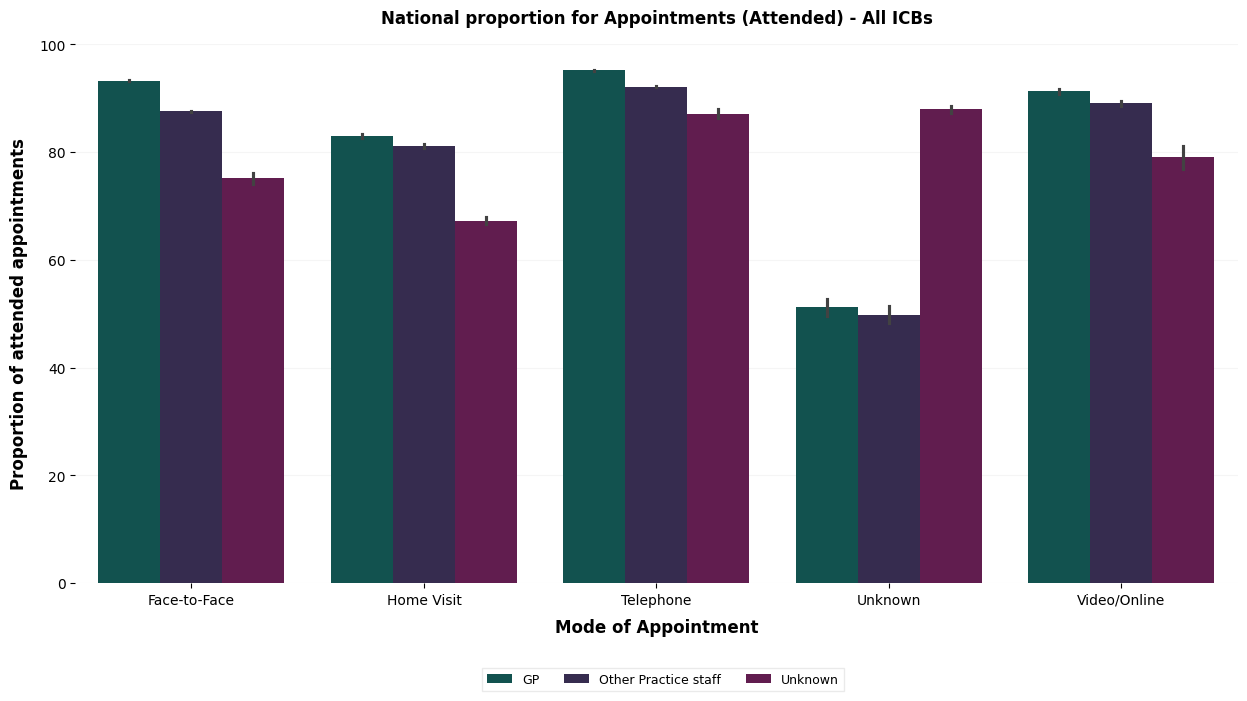

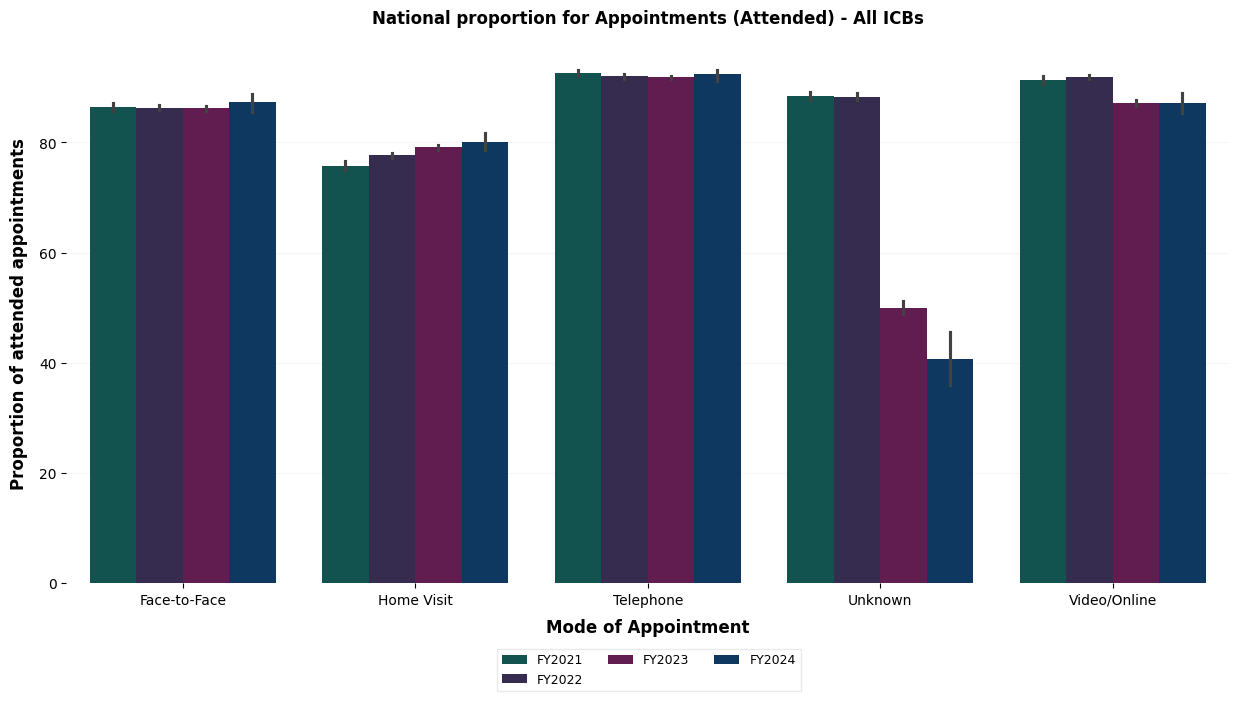

In [30]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.35,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

### **DNA Appointments** 

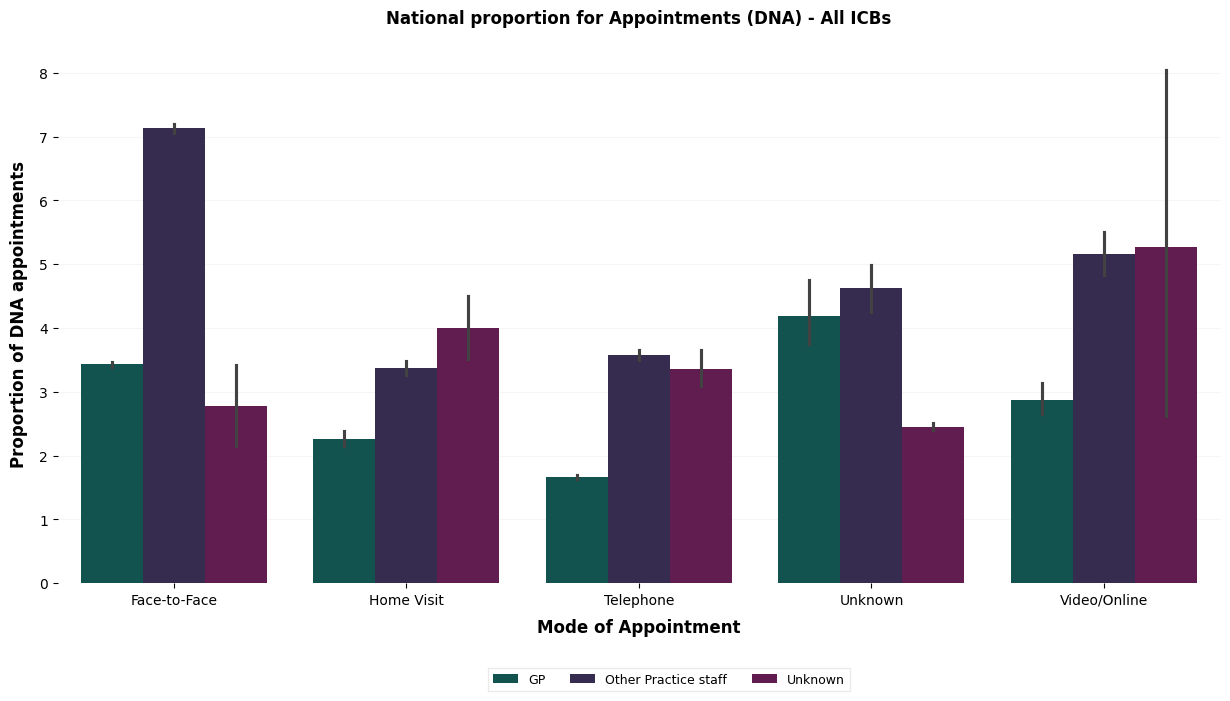

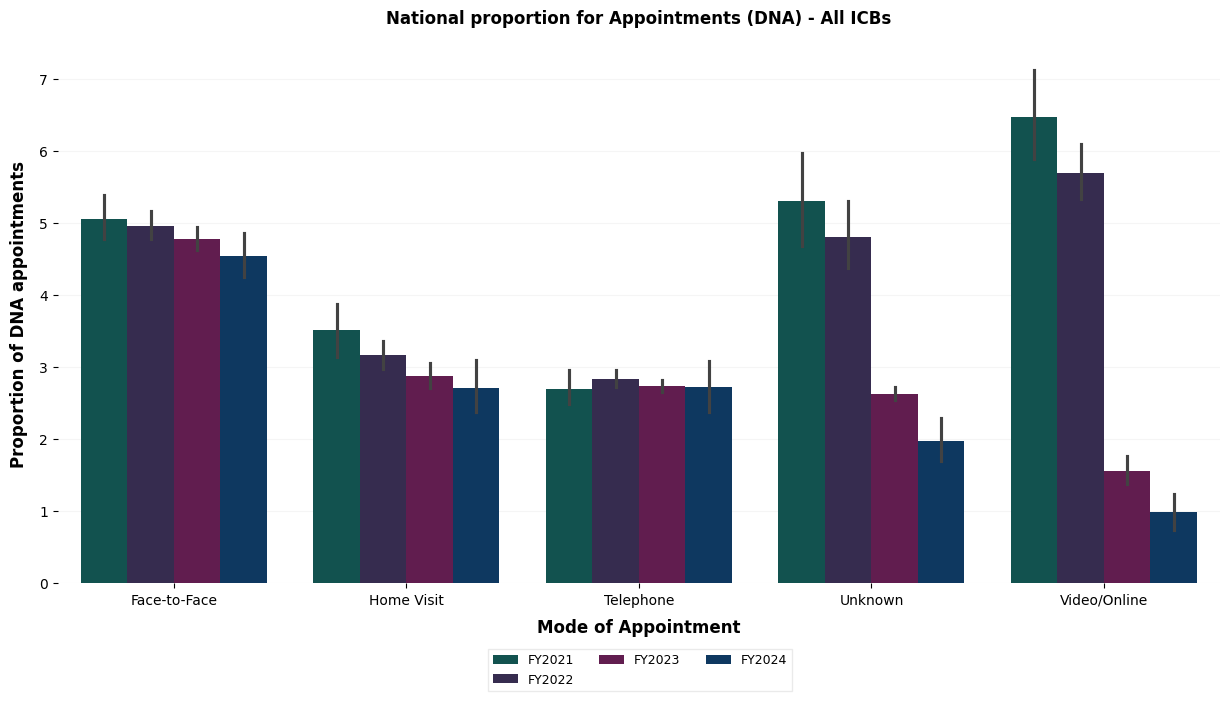

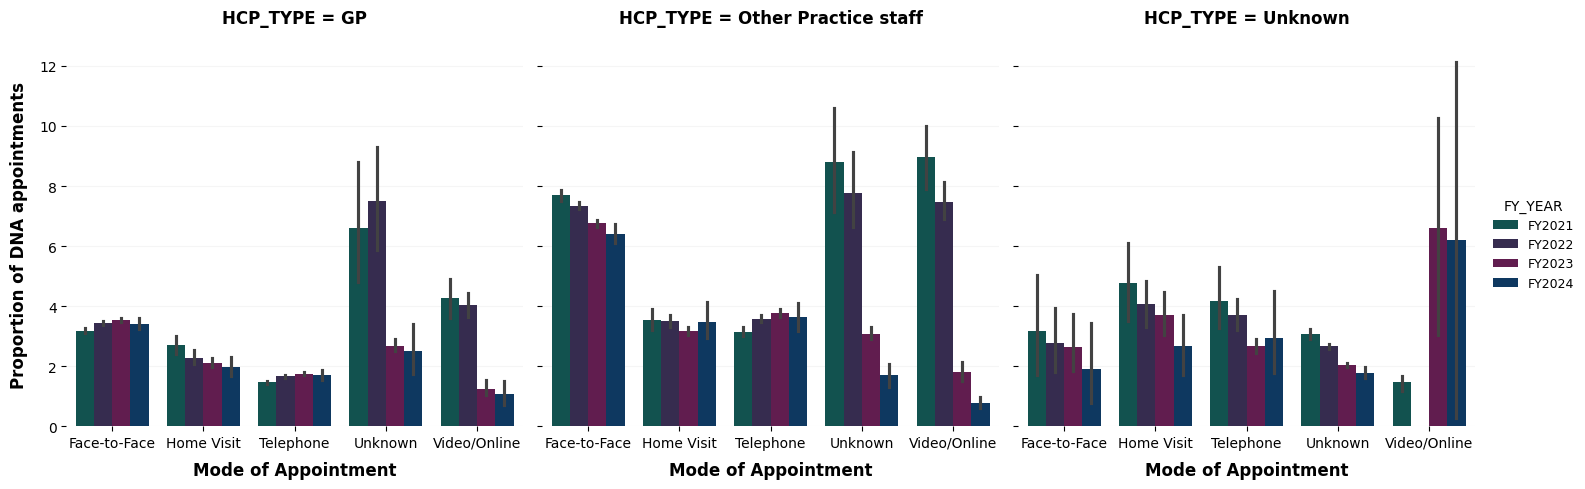

In [31]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df_plots)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

### **Correlation matrix all sub-icb's**

In [32]:
# Select categorical columns
categorical_columns = ['ICB_NAME','HCP_TYPE', 'APPT_MODE']

# Convert categorical columns to one-hot encoded features
one_hot_encoded = pd.get_dummies(appt_proportion_df_plots[categorical_columns])

dna_correlations_all_sub_icbs = one_hot_encoded.corrwith(appt_proportion_df_plots['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.177670
APPT_MODE_Face-to-Face                                                                    0.133800
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.123019
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.043219
ICB_NAME_NHS Black Country Integrated Care Board                                          0.039074
APPT_MODE_Video/Online                                                                    0.026115
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.025279
ICB_NAME_NHS Cheshire and Merseyside Integrated Care Board                                0.018859
ICB_NAME_NHS Staffordshire and Stoke-on-Trent Integrated Care Board                       0.018167
ICB_NAME_NHS South East London Integrated Care Board                                      0.017938
ICB_NAME_N

### **SNEE sub-icb Analysis**

In [33]:
snee_appt_proportion_df = appt_proportion_df_plots.loc[appt_proportion_df_plots['SUB_ICB_LOCATION_CODE'].isin(snee_sub_icb)]
snee_appt_proportion_df = snee_appt_proportion_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()
snee_appt_proportion_df

Attended       DNA  \
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR                        
06L                   GP       Face-to-Face FY2021   95.674000  1.472000   
                                            FY2022   95.175000  1.620833   
                                            FY2023   94.085833  1.625833   
                                            FY2024   94.830000  1.680000   
                               Home Visit   FY2021   94.264000  2.818000   
...                                                        ...       ...   
07K                   Unknown  Telephone    FY2023   88.890000       NaN   
                               Unknown      FY2021   95.508000  1.400000   
                                            FY2022   94.431667  1.933333   
                                            FY2023   92.633333  1.508333   
                                            FY2024   92.150000  1.290000   

                                                       Unknown  
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR             
06L                   GP       Face-to-Face FY2021    2.856000  
                                            FY2022    3.205000  
                                            FY2023    4.289167  
                                            FY2024    3.480000  
                               Home Visit   FY2021    2.920000  
...                                                        ...  
07K                   Unknown  Telephone    FY2023   66.665000  
                               Unknown      FY2021    3.094000  
                                            FY2022    3.632500  
                                            FY2023    5.857500  
                                            FY2024    6.560000  

[146 rows x 3 columns]

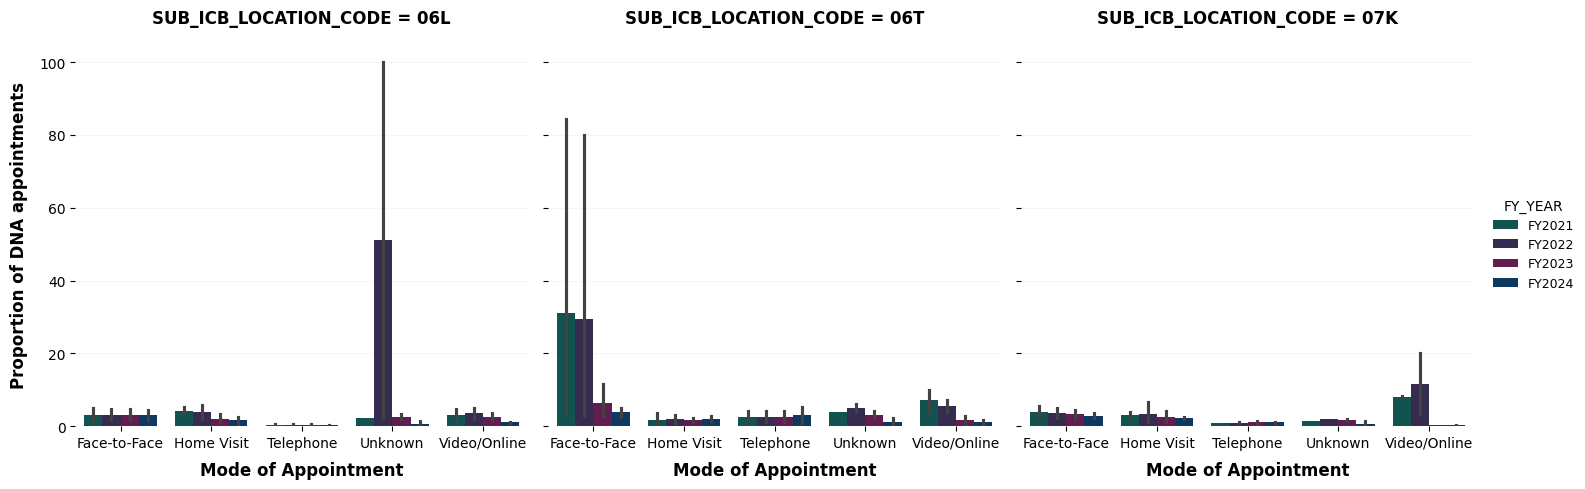

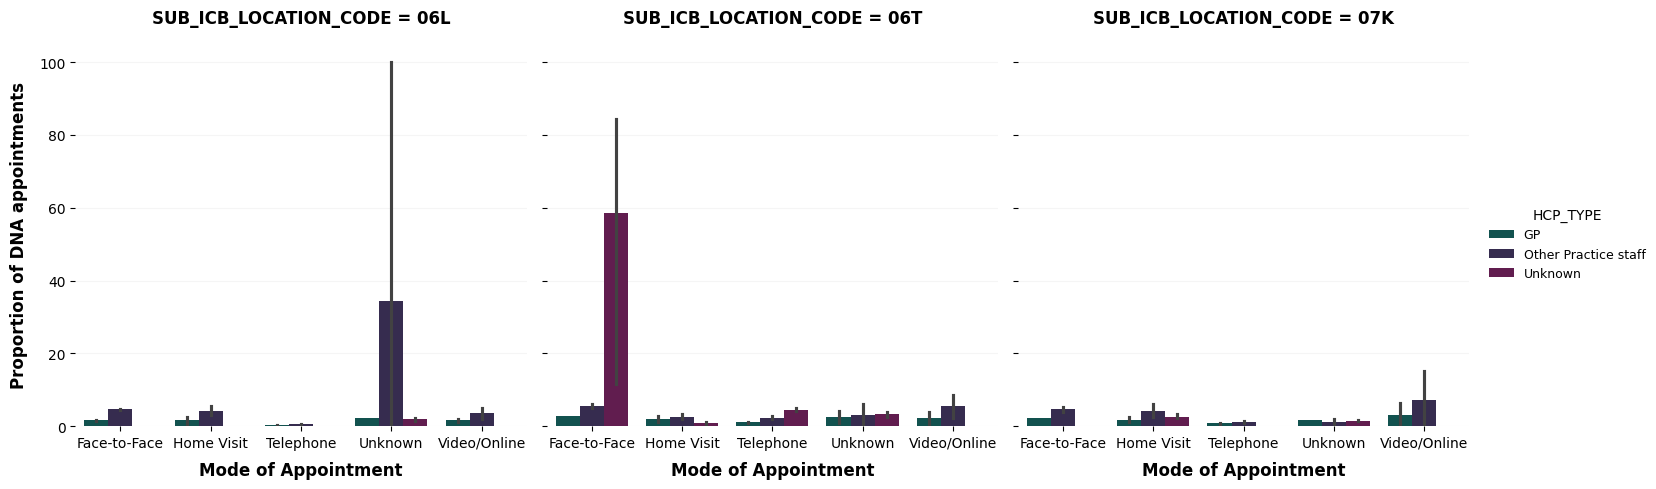

In [34]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

In [35]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

### **Correlation matrix SNEE sub-icb's**

In [36]:
snee_appt_proportion_df

,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,06L,GP,Face-to-Face,FY2021,95.674000,1.472000,2.856000
1,06L,GP,Face-to-Face,FY2022,95.175000,1.620833,3.205000
2,06L,GP,Face-to-Face,FY2023,94.085833,1.625833,4.289167
3,06L,GP,Face-to-Face,FY2024,94.830000,1.680000,3.480000
4,06L,GP,Home Visit,FY2021,94.264000,2.818000,2.920000
...,...,...,...,...,...,...,...
141,07K,Unknown,Telephone,FY2023,88.890000,NaN,66.665000
142,07K,Unknown,Unknown,FY2021,95.508000,1.400000,3.094000
143,07K,Unknown,Unknown,FY2022,94.431667,1.933333,3.632500
144,07K,Unknown,Unknown,FY2023,92.633333,1.508333,5.857500


In [37]:
cols = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']

# Convert categorical columns to one-hot encoded features
ce_OHE = pd.get_dummies(snee_appt_proportion_df[cols])

dna_correlations_snee_icbs = ce_OHE.corrwith(snee_appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.195147
HCP_TYPE_Unknown                 0.169729
SUB_ICB_LOCATION_CODE_06T        0.096668
APPT_MODE_Unknown                0.057544
HCP_TYPE_Other Practice staff    0.043030
SUB_ICB_LOCATION_CODE_06L       -0.002014
APPT_MODE_Video/Online          -0.030180
APPT_MODE_Home Visit            -0.090900
SUB_ICB_LOCATION_CODE_07K       -0.099132
APPT_MODE_Telephone             -0.125163
HCP_TYPE_GP                     -0.179429
dtype: float64


## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [38]:
print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

28898.14 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
31723.1 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,17140.6
FY2022,17822.6
FY2023,16479.8
FY2024,15710.0


- We can see that the each year's average for non-attended appointments for SNEE-ICB is much lesser than National Average.
  
- For year 2022, this difference increases as the National average is 31,568.7, whereas for SNEE-ICB it is 17,822.6

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

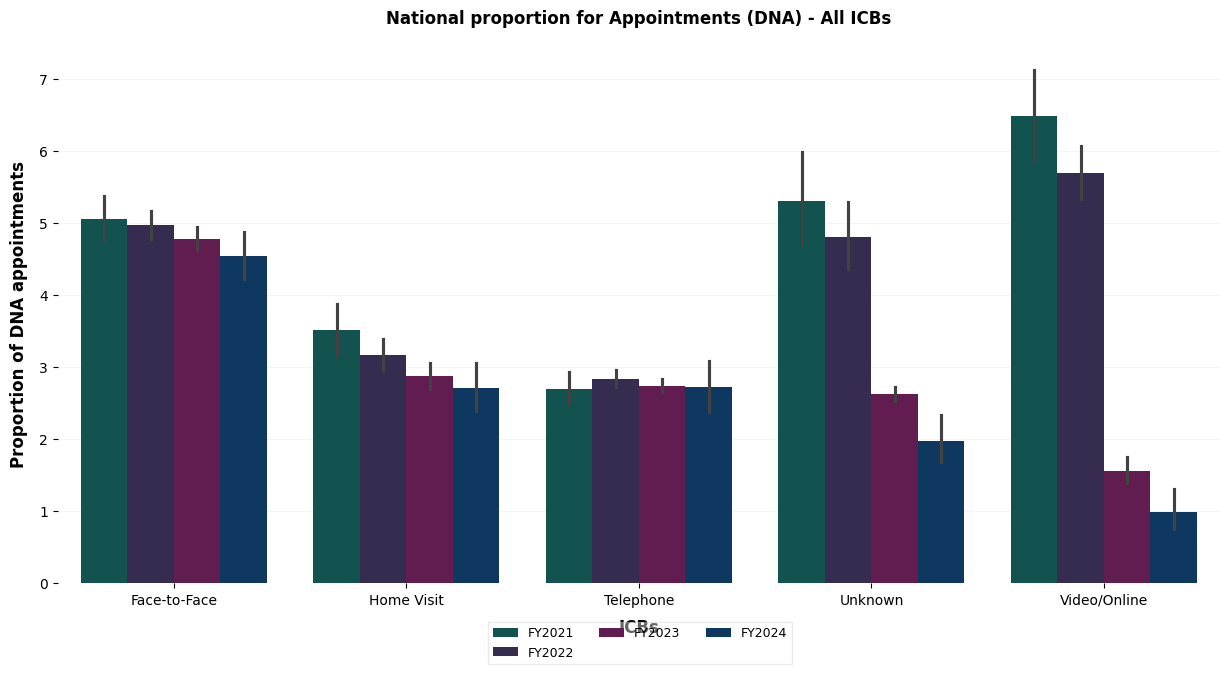

In [39]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.15), ncol=3)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

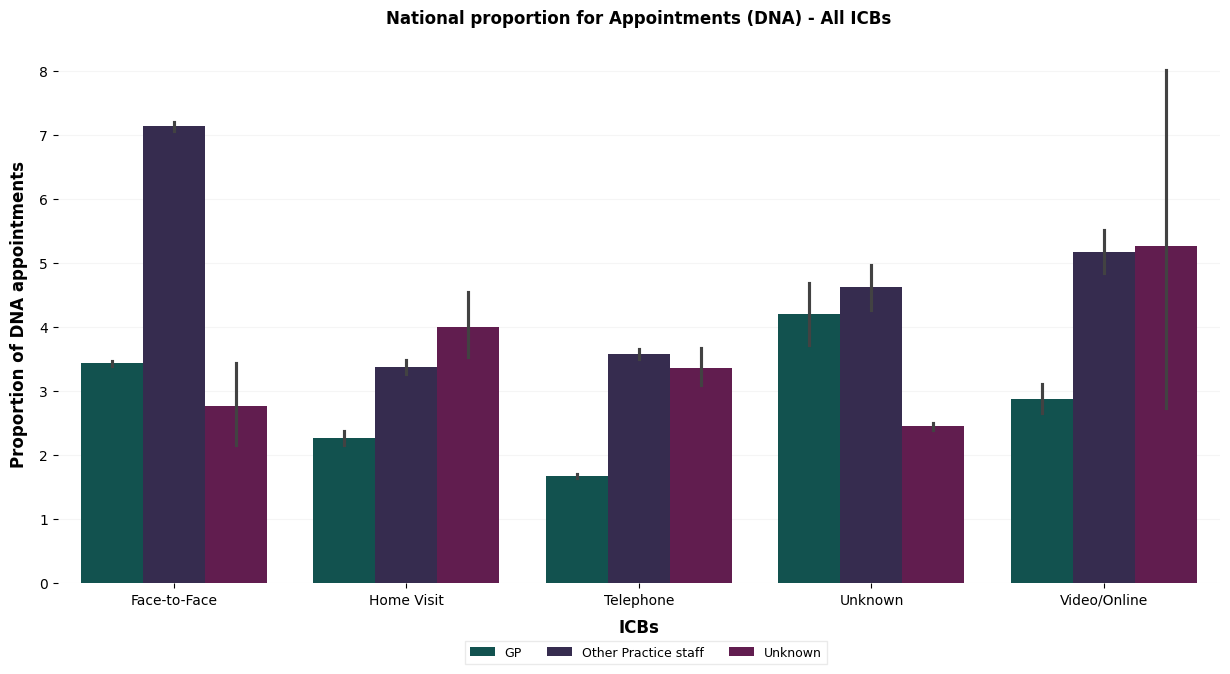

In [40]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.35,-0.15), ncol=3)
plt.show()

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
5. to determine if a patient with the above appointment will attend.

#### 1. **For Snee ICB'S**

In [41]:
print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.195147
HCP_TYPE_Unknown                 0.169729
SUB_ICB_LOCATION_CODE_06T        0.096668
APPT_MODE_Unknown                0.057544
HCP_TYPE_Other Practice staff    0.043030
SUB_ICB_LOCATION_CODE_06L       -0.002014
APPT_MODE_Video/Online          -0.030180
APPT_MODE_Home Visit            -0.090900
SUB_ICB_LOCATION_CODE_07K       -0.099132
APPT_MODE_Telephone             -0.125163
HCP_TYPE_GP                     -0.179429
dtype: float64


- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment_MODE = 'Face-to-face' and HCP_TYPE = 'Unknown', then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP_TYPE = 'GP', then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### 2. **For all sub-icbs(102)**

In [42]:
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.177670
APPT_MODE_Face-to-Face                                                                    0.133800
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.123019
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.043219
ICB_NAME_NHS Black Country Integrated Care Board                                          0.039074
APPT_MODE_Video/Online                                                                    0.026115
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.025279
ICB_NAME_NHS Cheshire and Merseyside Integrated Care Board                                0.018859
ICB_NAME_NHS Staffordshire and Stoke-on-Trent Integrated Care Board                       0.018167
ICB_NAME_NHS South East London Integrated Care Board                                      0.017938
ICB_NAME_N

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 6. Persist the distribution information from 5. to a yaml file.

In [43]:
years_to_keep = ['FY2022', 'FY2023']

filtered_df = appt_proportion_df_plots[appt_proportion_df_plots['FY_YEAR'].isin(years_to_keep)]

filtered_df = filtered_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH','FY_YEAR','Unknown','Attended']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).mean().round(2)
filtered_df = filtered_df.fillna(filtered_df.mean()).div(100).round(4)
filtered_df

DNA
SUB_ICB_LOCATION_CODE HCP_TYPE             APPT_MODE           
00L                   GP                   Face-to-Face  0.0224
                                           Home Visit    0.0186
                                           Telephone     0.0087
                                           Unknown       0.0239
                                           Video/Online  0.0248
...                                                         ...
X2C4Y                 Other Practice staff Telephone     0.0100
                                           Unknown       0.0388
                                           Video/Online  0.0404
                      Unknown              Face-to-Face  0.0360
                                           Unknown       0.0265

[1474 rows x 1 columns]

In [44]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [45]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[sub_icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[sub_icb_code]:
        nested_dna_proportion_dict[sub_icb_code][hcp_type] = {}
    nested_dna_proportion_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_dna_proportion_dict

{'00L': {'GP': {'Face-to-Face': 0.0224,
   'Home Visit': 0.0186,
   'Telephone': 0.0087,
   'Unknown': 0.0239,
   'Video/Online': 0.0248},
  'Other Practice staff': {'Face-to-Face': 0.0634,
   'Home Visit': 0.0105,
   'Telephone': 0.0232,
   'Unknown': 0.0254,
   'Video/Online': 0.0513},
  'Unknown': {'Face-to-Face': 0.0059,
   'Home Visit': 0.0067,
   'Telephone': 0.1429,
   'Unknown': 0.0246}},
 '00N': {'GP': {'Face-to-Face': 0.0317,
   'Home Visit': 0.0609,
   'Telephone': 0.0227,
   'Unknown': 0.036,
   'Video/Online': 0.0323},
  'Other Practice staff': {'Face-to-Face': 0.0642,
   'Home Visit': 0.0304,
   'Telephone': 0.0477,
   'Unknown': 0.036,
   'Video/Online': 0.0028},
  'Unknown': {'Face-to-Face': 0.0013,
   'Home Visit': 0.0173,
   'Telephone': 0.0296}},
 '00P': {'GP': {'Face-to-Face': 0.043,
   'Home Visit': 0.017,
   'Telephone': 0.0201,
   'Unknown': 0.013,
   'Video/Online': 0.0005},
  'Other Practice staff': {'Face-to-Face': 0.0754,
   'Home Visit': 0.017,
   'Telephone

In [46]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_dna_proportion_dict, yaml_file)

## Appointment Modes

In [59]:
# add financial year column
combined_df['FY'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH']).map(lambda x: f"FY{convert_to_fy(x)}")
fy_2023_appointments = combined_df.loc[combined_df['FY']=='FY2023'].groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).sum(numeric_only=True)
hcp_choice_df = round(fy_2023_appointments / fy_2023_appointments.reset_index().groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE']).sum(numeric_only=True),3)

nested_appointment_dict = {}

for key, value in hcp_choice_df.squeeze().to_dict().items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_appointment_dict:
        nested_appointment_dict[sub_icb_code] = {}
    if hcp_type not in nested_appointment_dict[sub_icb_code]:
        nested_appointment_dict[sub_icb_code][hcp_type] = {}
    nested_appointment_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_appointment_dict

OUTPUT_YAML_FILE = "outputs/assumptions/appointment_modes.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_appointment_dict, yaml_file)

/tmp/ipykernel_102552/1622935490.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['FY'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH']).map(lambda x: f"FY{convert_to_fy(x)}")


## Staff type

In [69]:

fy_2023_staff = combined_df.loc[combined_df['FY']=='FY2023'].groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE',]).sum(numeric_only=True)
hcp_person_df = round(fy_2023_staff / fy_2023_staff.reset_index().groupby(['SUB_ICB_LOCATION_CODE']).sum(numeric_only=True),4)

In [70]:
nested_staff_dict = {}

for key, value in hcp_person_df.squeeze().to_dict().items():
    sub_icb_code, hcp_type = key
    if sub_icb_code not in nested_staff_dict:
        nested_staff_dict[sub_icb_code] = {}
    if hcp_type not in nested_staff_dict[sub_icb_code]:
        nested_staff_dict[sub_icb_code][hcp_type] = value
    


OUTPUT_YAML_FILE = "outputs/assumptions/staff_propensity.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_staff_dict, yaml_file)